##  Proceso básico de exploración de datos con un conjunto de datos de carros.
Los datos, fueron todamos desde[aquí](https://github.com/luise-marquezb/Pyspark/blob/main/cars.csv)í. La idea es hacer una análisis general básico e implementar algunas gráficas que ayuden a comprender un poco mejor la información.


In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import IntegerType, StringType, StructField, StructType, DoubleType
from pyspark.sql.functions import col, lit, monotonically_increasing_id, udf
from pyspark.sql import functions as F
import os
import pandas as pd

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
spark = SparkSession.builder.appName("BasicExploration").config('spark.master', 'local[4]').config('spark.shuffle.sql.partitions', 1).getOrCreate()
spark

In [4]:
data_path = 'DataSets/cars.csv'

In [5]:
cars_df = spark.read.csv(data_path, sep=';', header=True)

In [6]:
cars_df.show(5, truncate=False)

+-------------------------+------+---------+------------+----------+------+------------+-----+------+
|Car                      |MPG   |Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+-------------------------+------+---------+------------+----------+------+------------+-----+------+
|STRING                   |DOUBLE|INT      |DOUBLE      |DOUBLE    |DOUBLE|DOUBLE      |INT  |CAT   |
|Chevrolet Chevelle Malibu|18.0  |8        |307.0       |130.0     |3504. |12.0        |70   |US    |
|Buick Skylark 320        |15.0  |8        |350.0       |165.0     |3693. |11.5        |70   |US    |
|Plymouth Satellite       |18.0  |8        |318.0       |150.0     |3436. |11.0        |70   |US    |
|AMC Rebel SST            |16.0  |8        |304.0       |150.0     |3433. |12.0        |70   |US    |
+-------------------------+------+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



Agregamos un índice para identificar cada fila

In [7]:
cars_df = cars_df.withColumn('index', monotonically_increasing_id())
cars_df.show(5, truncate=False)

+-------------------------+------+---------+------------+----------+------+------------+-----+------+-----+
|Car                      |MPG   |Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|index|
+-------------------------+------+---------+------------+----------+------+------------+-----+------+-----+
|STRING                   |DOUBLE|INT      |DOUBLE      |DOUBLE    |DOUBLE|DOUBLE      |INT  |CAT   |0    |
|Chevrolet Chevelle Malibu|18.0  |8        |307.0       |130.0     |3504. |12.0        |70   |US    |1    |
|Buick Skylark 320        |15.0  |8        |350.0       |165.0     |3693. |11.5        |70   |US    |2    |
|Plymouth Satellite       |18.0  |8        |318.0       |150.0     |3436. |11.0        |70   |US    |3    |
|AMC Rebel SST            |16.0  |8        |304.0       |150.0     |3433. |12.0        |70   |US    |4    |
+-------------------------+------+---------+------------+----------+------+------------+-----+------+-----+
only showing top 5 rows



Eliminamos la primera fila que es solo informativa

In [8]:
cars_df = cars_df.filter(~cars_df.index.isin([0]))
cars_df = cars_df.drop('index')
cars_df.show(5, truncate=False)

+-------------------------+----+---------+------------+----------+------+------------+-----+------+
|Car                      |MPG |Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+-------------------------+----+---------+------------+----------+------+------------+-----+------+
|Chevrolet Chevelle Malibu|18.0|8        |307.0       |130.0     |3504. |12.0        |70   |US    |
|Buick Skylark 320        |15.0|8        |350.0       |165.0     |3693. |11.5        |70   |US    |
|Plymouth Satellite       |18.0|8        |318.0       |150.0     |3436. |11.0        |70   |US    |
|AMC Rebel SST            |16.0|8        |304.0       |150.0     |3433. |12.0        |70   |US    |
|Ford Torino              |17.0|8        |302.0       |140.0     |3449. |10.5        |70   |US    |
+-------------------------+----+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



Vemos que todas las columnas son de tipo string, por lo que necesitamos generar un esquema que defina el tipo correcto de cada columna.

In [9]:
cars_df.printSchema()

root
 |-- Car: string (nullable = true)
 |-- MPG: string (nullable = true)
 |-- Cylinders: string (nullable = true)
 |-- Displacement: string (nullable = true)
 |-- Horsepower: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- Acceleration: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Origin: string (nullable = true)



Antes de modificar el esquema, debemos realizar una transformación en la columna _Weight_ pues esta no corresponde a valores de tipo *Double*

In [10]:
cars_df = cars_df.withColumn('Weight', F.split('Weight', '\.')[0].cast(IntegerType()))
cars_df.show(5)

+--------------------+----+---------+------------+----------+------+------------+-----+------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|
|  Plymouth Satellite|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|
|       AMC Rebel SST|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|
|         Ford Torino|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



In [11]:
cars_df.show(10, truncate=False)

+-------------------------+----+---------+------------+----------+------+------------+-----+------+
|Car                      |MPG |Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+-------------------------+----+---------+------------+----------+------+------------+-----+------+
|Chevrolet Chevelle Malibu|18.0|8        |307.0       |130.0     |3504  |12.0        |70   |US    |
|Buick Skylark 320        |15.0|8        |350.0       |165.0     |3693  |11.5        |70   |US    |
|Plymouth Satellite       |18.0|8        |318.0       |150.0     |3436  |11.0        |70   |US    |
|AMC Rebel SST            |16.0|8        |304.0       |150.0     |3433  |12.0        |70   |US    |
|Ford Torino              |17.0|8        |302.0       |140.0     |3449  |10.5        |70   |US    |
|Ford Galaxie 500         |15.0|8        |429.0       |198.0     |4341  |10.0        |70   |US    |
|Chevrolet Impala         |14.0|8        |454.0       |220.0     |4354  |9.0         |70   |US    |


In [12]:
cars_df = cars_df.withColumn("Car", col("Car").cast(StringType()))
cars_df = cars_df.withColumn("MPG", col("MPG").cast(DoubleType()))
cars_df = cars_df.withColumn("Cylinders", col("Cylinders").cast(IntegerType()))
cars_df = cars_df.withColumn("Displacement", col("Displacement").cast(DoubleType()))
cars_df = cars_df.withColumn("Horsepower", col("Horsepower").cast(DoubleType()))
cars_df = cars_df.withColumn("Weight", col("Weight").cast(IntegerType()))
cars_df = cars_df.withColumn("Acceleration", col("Acceleration").cast(DoubleType()))
cars_df = cars_df.withColumn("Model", col("Model").cast(IntegerType()))
cars_df = cars_df.withColumn("Origin", col("Origin").cast(StringType()))

In [13]:
cars_df.printSchema()

root
 |-- Car: string (nullable = true)
 |-- MPG: double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Displacement: double (nullable = true)
 |-- Horsepower: double (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Acceleration: double (nullable = true)
 |-- Model: integer (nullable = true)
 |-- Origin: string (nullable = true)



In [14]:
cars_df.show(10, truncate=False)

+-------------------------+----+---------+------------+----------+------+------------+-----+------+
|Car                      |MPG |Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+-------------------------+----+---------+------------+----------+------+------------+-----+------+
|Chevrolet Chevelle Malibu|18.0|8        |307.0       |130.0     |3504  |12.0        |70   |US    |
|Buick Skylark 320        |15.0|8        |350.0       |165.0     |3693  |11.5        |70   |US    |
|Plymouth Satellite       |18.0|8        |318.0       |150.0     |3436  |11.0        |70   |US    |
|AMC Rebel SST            |16.0|8        |304.0       |150.0     |3433  |12.0        |70   |US    |
|Ford Torino              |17.0|8        |302.0       |140.0     |3449  |10.5        |70   |US    |
|Ford Galaxie 500         |15.0|8        |429.0       |198.0     |4341  |10.0        |70   |US    |
|Chevrolet Impala         |14.0|8        |454.0       |220.0     |4354  |9.0         |70   |US    |


In [47]:
cylinders = cars_df.groupBy('Cylinders').count().sort('Cylinders')
cylinders_pd_df = cylinders.toPandas()
cylinders_pd_df = cylinders_pd_df.set_index('Cylinders')

In [53]:
cylinders_pd_df#.sort_values(by='count', ascending=True)

,count
Cylinders,
3,4
4,207
5,3
6,84
8,108


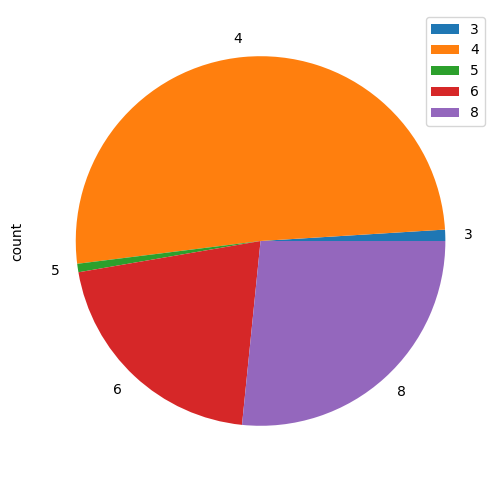

In [50]:
cylinders_pd_df.plot.pie(y='count' ,figsize=(11, 6));

In [17]:
models = cars_df.groupBy('Model').count().sort('Model')
models_pd_df = models.toPandas()

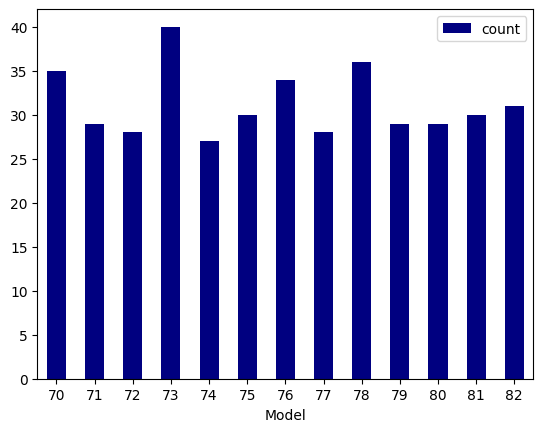

In [18]:
ax = models_pd_df.plot.bar(x='Model', y='count', rot=0, color={"navy"})

In [19]:
origin = cars_df.groupBy('Origin').count()
origin.show()

+------+-----+
|Origin|count|
+------+-----+
|Europe|   73|
|    US|  254|
| Japan|   79|
+------+-----+



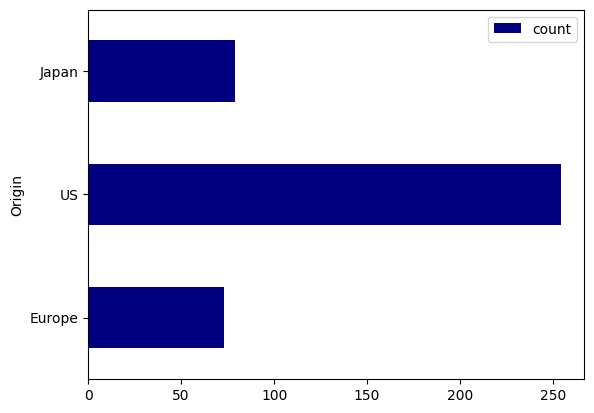

In [20]:
origin_pd_df = origin.toPandas()
ax = origin_pd_df.plot.barh(x='Origin', y='count', rot=0, color={"navy"})

In [21]:
import findspark
findspark.init()

In [22]:
cars_df.show(2)

+--------------------+----+---------+------------+----------+------+------------+-----+------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
only showing top 2 rows



In [23]:
horsepower_1 = cars_df.filter(F.col('Horsepower') <= 50).select('Horsepower').count()
horsepower_2 = cars_df.filter( (F.col('Horsepower') > 50) & (F.col('Horsepower') <= 100) ).select('Horsepower').count()
horsepower_3 = cars_df.filter( (F.col('Horsepower') > 100) & (F.col('Horsepower') <= 150) ).select('Horsepower').count()
horsepower_4 = cars_df.filter( (F.col('Horsepower') > 150) & (F.col('Horsepower') <= 200) ).select('Horsepower').count()
horsepower_5 = cars_df.filter( (F.col('Horsepower') > 200) ).select('Horsepower').count()


In [24]:
horsepower_1, horsepower_2, horsepower_3, horsepower_4, horsepower_5

(13, 236, 108, 39, 10)

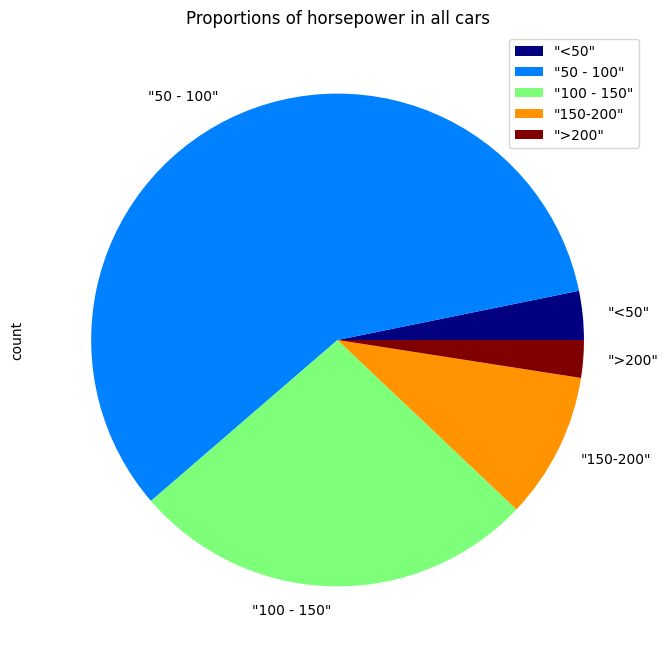

In [26]:
horsepower_df = pd.DataFrame(
    {'count': [horsepower_1, 
               horsepower_2, 
               horsepower_3, 
               horsepower_4, 
               horsepower_5]},
    index = ['"<50"', 
             '"50 - 100"', 
             '"100 - 150"', 
             '"150-200"', 
             '">200"']
)

plot = horsepower_df.plot.pie(y='count', 
                              figsize=(8, 8),
                              colormap='jet',
                              title='Proportions of horsepower in all cars'
                             )

# 

## Nota:
Es posible transformar filas del dataframe mediante udf functions. Basta con definir la función de manera natural y luego mapearla mediante Functions.udf.
Con este método, la última agregación sería mucho más sencilla.

In [27]:
def get_category_horsepower(horsepower):
    try:
        if horsepower < 50:
            return "Menor a 50"
        if horsepower >= 50 and horsepower < 100:
            return "50 - 100"
        if horsepower >= 100 and horsepower < 150:
            return "100 - 150"
        if horsepower >= 150 and horsepower < 200:
            return "150 - 200"
        else:
            return "Mayor a 200"
    except:
        return "error"


In [29]:
from pyspark.errors import PySparkException

category_horsepower_udf = F.udf(get_category_horsepower, StringType())
try:
    horsepower_category_df = cars_df.withColumn("Horsepower_Cat", category_horsepower_udf(col("Horsepower")))
except PySparkException as err:
    print(str(err))

In [30]:
horsepower_category_df.show()

+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|Horsepower_Cat|
+--------------------+----+---------+------------+----------+------+------------+-----+------+--------------+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|     100 - 150|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|     150 - 200|
|  Plymouth Satellite|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|     150 - 200|
|       AMC Rebel SST|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|     150 - 200|
|         Ford Torino|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|     100 - 150|
|    Ford Galaxie 500|15.0|        8|       429.0|     198.0|  4341|        10.0|   70|    US|     150 - 200|
|    Chevr

In [54]:
horsepower = horsepower_category_df.groupBy('Horsepower_Cat').count().sort('count')
horsepower_category_pd_df = horsepower.toPandas()
horsepower_category_pd_df = horsepower_category_pd_df.set_index('Horsepower_Cat')

In [55]:
horsepower_category_pd_df

,count
Horsepower_Cat,
Mayor a 200,11
Menor a 50,13
150 - 200,60
100 - 150,103
50 - 100,219


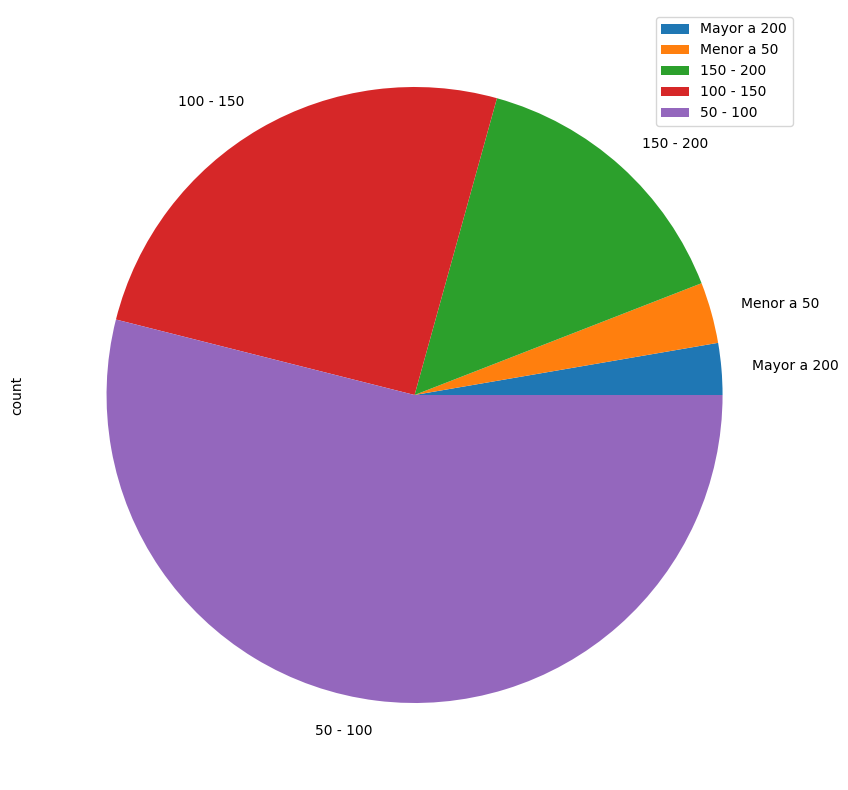

In [63]:
horsepower_category_pd_df.plot.pie(y='count', figsize=(10, 10));